<a href="https://colab.research.google.com/github/luizgontijo/DataScience_Projects/blob/master/fraud_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Classification

This notebook proposes an analysis in a dataset of fraud samples of access to a certain website. The purpose of the analyzes is to obtain a good classification algorithm for new accesses. Being able to quickly predict if the access is made by a real person or by some fraud mechanism.


# Chapter 01 - Introducing the problem and presenting the data

As we will see in this chapter, we will be working with two datasets. The first indicates purchases made on a given website and the second indicates the IP values ​​related to different countries

To see and analyse this dataset, first we have to import some libraries:

In [3]:
import numpy as np
import pandas as pd
from scipy import special

import itertools
from datetime import timedelta
from IPython.display import display

Now import the data.

In [4]:
fraud_df = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/Fraud_Data.csv', header = 0)

In [5]:
fraud_df = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/fraud_df.csv', header = 0)
ISP_df = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/isp_df.csv', header=0)

The fraud_df indicates

In [6]:
fraud_df.head()

,Unnamed: 0,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
ISP_df.head()

,Unnamed: 0,inf_limit_ip,sup_limit_ip,country_ip
0,0,16777216.0,16777471,Australia
1,1,16777472.0,16777727,China
2,2,16777728.0,16778239,China
3,3,16778240.0,16779263,Australia
4,4,16779264.0,16781311,China


Do not use the firt column of both datasets:


In [8]:
fraud_df = fraud_df.iloc[:, 1:]
ISP_df = ISP_df.iloc[:, 1:]

In [9]:
fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [10]:
ISP_df.head()

,inf_limit_ip,sup_limit_ip,country_ip
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


Verify if there is any null value in the data

In [11]:
for col in fraud_df.columns:
  print('# null values in {}: {}'.format(col, fraud_df[col].isnull().sum()))

# null values in id: 0
# null values in register: 0
# null values in purchase: 0
# null values in value: 0
# null values in id_divice: 0
# null values in source: 0
# null values in browser: 0
# null values in gender: 0
# null values in age: 0
# null values in ip: 0
# null values in fraud: 0


In [12]:
for col in ISP_df.columns:
  print('# null values in {}: {}'.format(col, ISP_df[col].isnull().sum()))

# null values in inf_limit_ip: 0
# null values in sup_limit_ip: 0
# null values in country_ip: 0


Look at the descriptive statistics of the data

In [13]:
# verificar estatísticas descritivas nas colunas
fraud_df.describe()

,id,value,age,ip,fraud
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Show the type of the data in each column:

In [14]:
for col in fraud_df.columns:
  print('{}: {}'.format(col, fraud_df[col].dtype))

id: int64
register: object
purchase: object
value: int64
id_divice: object
source: object
browser: object
gender: object
age: int64
ip: float64
fraud: int64


In [15]:
for col in ISP_df.columns:
  print('{}: {}'.format(col, ISP_df[col].dtype))

inf_limit_ip: float64
sup_limit_ip: int64
country_ip: object


Fot the IP values, verify if they are really float:

In [16]:
ip_floats = ISP_df.inf_limit_ip.apply(lambda x: not x.is_integer()).sum()
print('Decimal different to zero in the inferior limit ip {}'.format(ip_floats))

Decimal different to zero in the inferior limit ip 0


As seen, IP values ​​classified as float have only zero after the decimal.


Now verify if the inferior limits and the superior limits are really the max and minimun values of the ip numbers:

In [17]:
display(ISP_df[ISP_df.inf_limit_ip == ISP_df.inf_limit_ip.max()])
display(ISP_df[ISP_df.sup_limit_ip == ISP_df.sup_limit_ip.max()])

# limite inferior e superior são diferentes
# na tabela de cima corta o fim dos números por que representar numeros inteiros como floats


,inf_limit_ip,sup_limit_ip,country_ip
138845,3.758096e+09,3758096383,Australia


,inf_limit_ip,sup_limit_ip,country_ip
138845,3.758096e+09,3758096383,Australia


Now create just one dataset. For that, we must associate the fraud table IP with the ISP table IP to find out the country of each access.

First we have to see if the IP of the access is in the IP of the list:


In [18]:
# podemos agora associar os dois bancos de dados
# saber quantos endereços de ip tem paísses exlusicvos
# saber quantas fraudes vieram de cada país

# fazer leitura de todos os IPs no banco de fraudes e saber se estão no outro banco de dados

# function to verify if the ip of the access is in the IP of the ISP table
def isp_counts(isp):
  country = ISP_df[(ISP_df.inf_limit_ip <= isp) & (ISP_df.sup_limit_ip >= isp)].country_ip

  if country.shape[0] == 1:
    return print("Single") # if just one occurrence of this IP
  elif country.shape[0] > 1:
    return print('Many countries') # if the ip is repeated for many countries
  elif country.shape[0] == 0:
    if isp > ISP_df.sup_limit_ip.max():
      return print('Very high IP number') # if ip is a very high number
    elif isp < ISP_df.inf_limit_ip.min():
      return print('Very low ip number') # if ip is a very low number
    else:
      return print('Missing IP') # if the ip is missing in the data frame

ip_counts = fraud_df.ip.apply(isp_counts)
print(ip_counts.value_counts())

A saída de streaming foi truncada nas últimas 5000 linhas.
Missing IP
Single
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Single
Single
Single
Single
Single
Very high IP number
Single
Very high IP number
Single
Single
Single
Single
Single
Very high IP number
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Very low ip number
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Single
Very high IP number
Sing

Now identify access without IP:

In [19]:
def ip_to_country(ip):
    tmp = ISP_df[(ISP_df.inf_limit_ip <= ip)
                & (ISP_df.sup_limit_ip >= ip)].country_ip
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return print("Missing")
    elif tmp.shape[0] > 1:
        return print("Error")
    
fraud_df["country"] = fraud_df.ip.apply(ip_to_country)

A saída de streaming foi truncada nas últimas 5000 linhas.
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missi

Now see the new dataset with the country of each access:

In [20]:
fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Save this new data frame:

In [21]:
fraud_df.to_csv('/content/drive/MyDrive/Alura/detec_fraude/data_fraud_with_country', index = False)

In [22]:
fraud_df = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/data_fraud_with_country', header = 0)

fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [23]:
fraud_df.sample(10)

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country
38588,135275,2015-05-14 14:52:02,2015-06-09 07:24:23,14,LQMNWIDJSYVVF,Ads,Chrome,M,39,4.160539e+09,0,NaN
135428,386302,2015-06-04 23:46:37,2015-08-16 06:53:16,27,RTJUMBDYXQHPB,SEO,Safari,M,24,5.309241e+08,0,Switzerland
134030,10072,2015-01-14 00:48:23,2015-04-12 22:36:36,42,PAJCMBHGRQRMY,SEO,IE,F,31,4.413102e+08,0,United States
124701,326633,2015-01-01 19:14:55,2015-01-04 16:59:27,30,HRXAEPUDDYUYZ,SEO,FireFox,F,22,2.476303e+09,0,United States
113660,40769,2015-06-06 08:55:36,2015-08-10 22:41:08,47,XXUEOIUCCLNOQ,Ads,IE,F,26,4.156392e+09,0,NaN
66837,230304,2015-01-20 02:08:27,2015-02-05 13:30:37,43,UKOHTOXIAKBAR,SEO,FireFox,M,21,2.580139e+09,0,Japan
121184,255039,2015-04-06 11:29:56,2015-06-27 15:58:46,20,DLYRYEVSMJHNH,SEO,Chrome,F,31,4.156315e+09,0,NaN
20690,260152,2015-02-10 05:09:26,2015-05-24 06:50:28,21,VRDFGDDEAPAHC,Ads,Safari,F,36,1.749769e+09,0,United States
110225,77130,2015-06-05 20:41:27,2015-09-29 07:11:56,33,AWZQEAAGXSDHU,SEO,Safari,F,32,3.719012e+09,1,Japan
9569,137368,2015-07-31 21:16:11,2015-08-22 16:22:22,28,GKKWKSLHFHTVX,Direct,Chrome,F,27,3.273297e+09,0,Macedonia


 # Chapter 02 - Exploratory Data Analysis

Now some visualizations to undesrtant the data and present some alternatives for its use.



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

See the amout of fraud for each gender

Text(0, 0.5, 'cases')

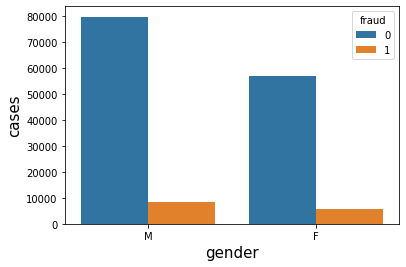

In [25]:
sns.countplot(x="gender", hue='fraud', data=fraud_df)
plt.xlabel("gender", fontsize=15)
plt.ylabel("cases", fontsize=15)


There is no significant difference between the amount of fraud by gender



Now the amout of frauds for source of marketing of the.


Text(0, 0.5, 'cases')

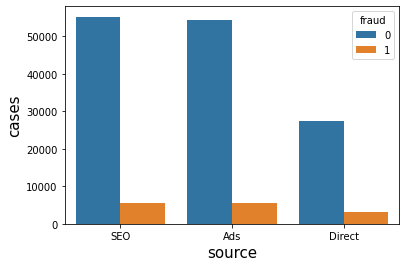

In [26]:
# relacionar a fonte de marketing e fraude
sns.countplot(x="source", hue='fraud', data=fraud_df)
plt.xlabel("source", fontsize=15)
plt.ylabel("cases", fontsize=15)

Fraud for direct access to the site is less. Accesses by adds, on the other hand, provide greater frequency of fraud.

Now the amout of frauds for browser:


Text(0, 0.5, 'cases')

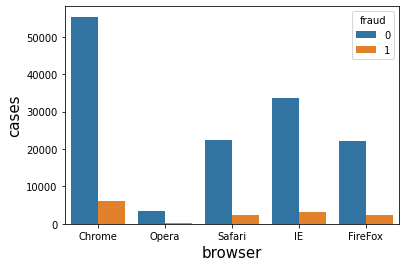

In [27]:
sns.countplot(x="browser", hue='fraud', data=fraud_df)
plt.xlabel("browser", fontsize=15)
plt.ylabel("cases", fontsize=15)

Fraud using google chrome was much more frequent. This is motivated by the greater use of this browser compared to others.

Now see the frequency of frauds for each hour of the day:

In [28]:
columns = ['fraud', 'register', 'purchase']

tmp_df = pd.DataFrame(columns = columns)
tmp_df[columns] = fraud_df[columns]

In [29]:
tmp_df.register = tmp_df['register'].apply(pd.to_datetime)
tmp_df.purchase = tmp_df['purchase'].apply(pd.to_datetime)

# time between register and purchase:
tmp_df['time_reg_purc'] = (tmp_df.purchase - tmp_df.register).apply(lambda x: x.seconds)

Text(0, 0.5, 'cases')

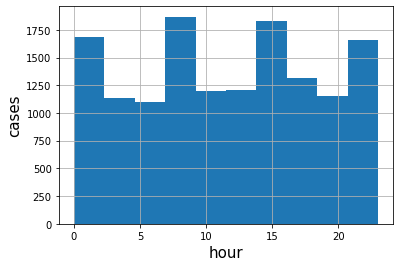

In [30]:
tmp_df[tmp_df['fraud'] == 1].register.apply(lambda x: x.hour).hist()
plt.xlabel('hour', fontsize = 15)
plt.ylabel('cases', fontsize = 15)

There is some peaks of cases during the day, but the frequency is higher between 20h and 00h.

Now see the frequency of frauds for each day of the week:

Text(0, 0.5, 'cases')

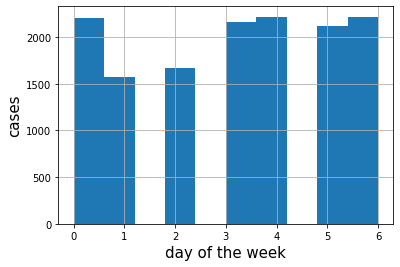

In [31]:
tmp_df[tmp_df['fraud'] == 1].register.apply(lambda x: x.dayofweek).hist()
plt.xlabel('day of the week', fontsize = 15)
plt.ylabel('cases', fontsize = 15)

The cases are well spread during the days of the week.

Now see the frequency of frauds for each mounth of the year:


Text(0, 0.5, 'cases')

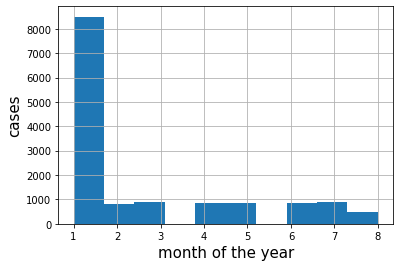

In [32]:
tmp_df[tmp_df['fraud'] == 1].register.apply(lambda x: x.month).hist()
plt.xlabel('month of the year', fontsize = 15)
plt.ylabel('cases', fontsize = 15)

The early months have a huge amount of cases. 

Now see the frequency of frauds for each week of the year:

Text(0, 0.5, 'cases')

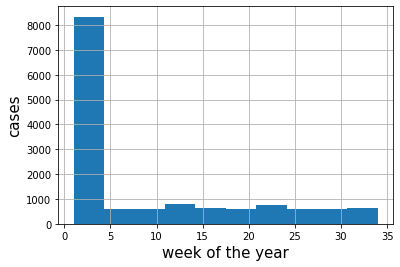

In [33]:
tmp_df[tmp_df['fraud'] == 1].register.apply(lambda x: x.week).hist()
plt.xlabel('week of the year', fontsize = 15)
plt.ylabel('cases', fontsize = 15)

As was observed for the previous case, the number of cases at the beginning and the year are much higher. This can be explained by the access to the websites to buy Christmas gifts, for example.



Now we can see the relationship between registration and purchase for fraud and non-fraud.

In [34]:
tmp_df.head()

,fraud,register,purchase,time_reg_purc
0,0,2015-02-24 22:55:49,2015-04-18 02:47:11,13882
1,0,2015-06-07 20:39:50,2015-06-08 01:38:54,17944
2,1,2015-01-01 18:52:44,2015-01-01 18:52:45,1
3,0,2015-04-28 21:13:25,2015-05-04 13:54:50,60085
4,0,2015-07-21 07:09:52,2015-09-09 18:40:53,41461


Text(0, 0.5, 'time between registration and purchase')

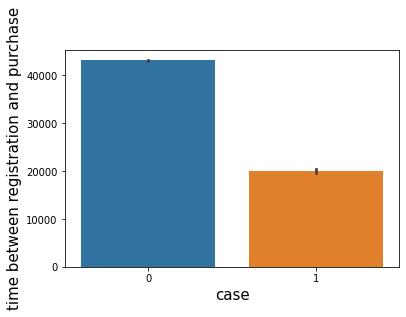

In [35]:
sns.barplot(x='fraud', y='time_reg_purc', data=tmp_df)
plt.xlabel('case', fontsize=15)
plt.ylabel('time between registration and purchase', fontsize=15)

Cases with longer time between registration and purchase are much greater for cases of non-fraud than for cases of fraud.

Now see the frequency of cases for each country:

In [36]:
sums_f = fraud_df[fraud_df['fraud']==1]['fraud'].groupby(fraud_df.country).sum()
sums_f = sums_f.to_frame().reset_index()

sums_nf = fraud_df[fraud_df['fraud']==0]['fraud'].groupby(fraud_df.country).sum()
sums_nf = sums_nf.to_frame().reset_index()


In [37]:
sums_f.head()

,country,fraud
0,Afghanistan,1
1,Algeria,13
2,Angola,1
3,Argentina,66
4,Armenia,2


In [38]:
sums_nf.head()

,country,fraud
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Angola,0
4,Antigua and Barbuda,0


Text(0, 0.5, 'country')

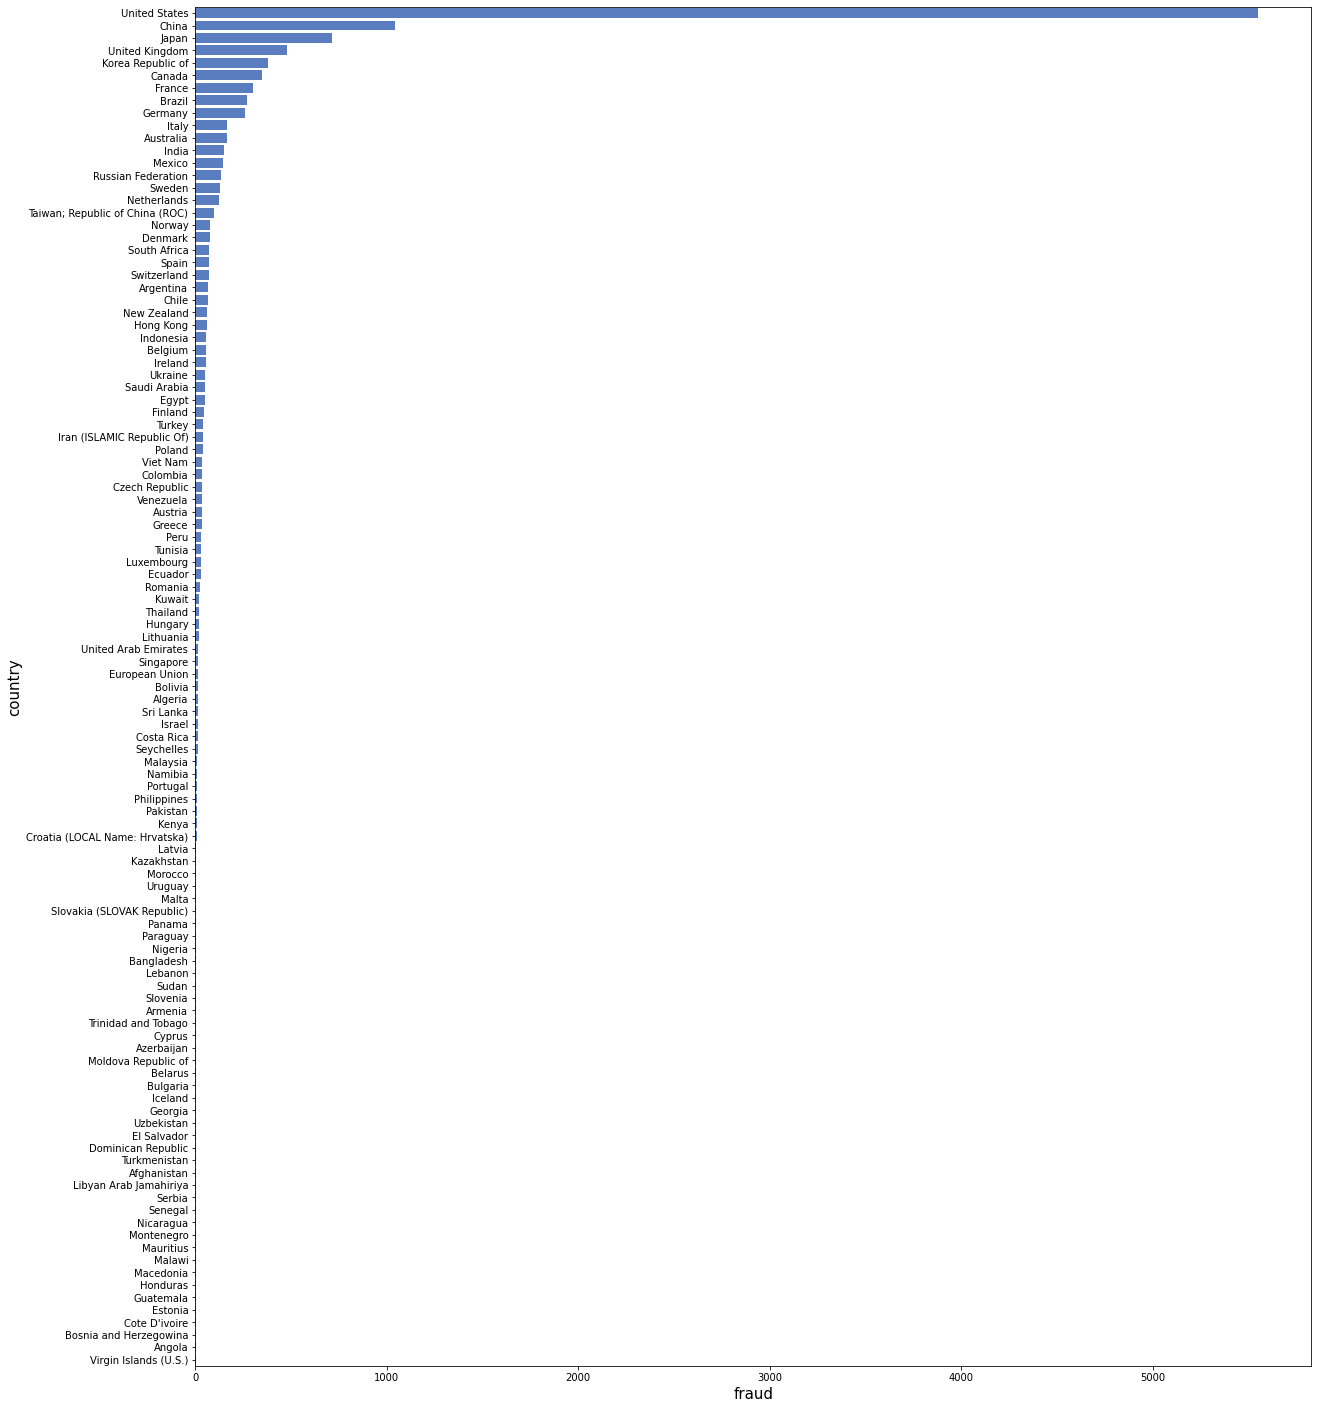

In [39]:
# use just the data frame with coutries tha have some fraud
temp_sum = sums_f.sort_values('fraud', ascending=False)

f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes('muted')
sns.barplot(x='fraud', y='country', data=temp_sum, label='Total', color='b')
plt.xlabel('fraud', fontsize=15)
plt.ylabel('country', fontsize=15)

The United States has a much larger number of cases than other countries.

We can check the user (device and ip) rate with a single registration and see if the majority indicates fraud or not.

In [40]:
fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [41]:
tmp_df = pd.DataFrame(columns = ['fraud', 'id_per_device', 'id_per_ip'])
tmp_df['fraud'] = fraud_df['fraud']

userid_count = fraud_df.groupby('id_divice').id.count()
tmp_df['id_per_device'] = fraud_df.id_divice.apply(lambda x: userid_count[x])

userid_count2 = fraud_df.groupby('ip').id.count()
tmp_df['id_per_ip'] = fraud_df.ip.apply(lambda x: userid_count2[x])


In [42]:
tmp_df.head()

,fraud,id_per_device,id_per_ip
0,0,1,1
1,0,1,1
2,1,12,12
3,0,1,1
4,0,1,1


Text(0, 0.5, 'id per dispositivo')

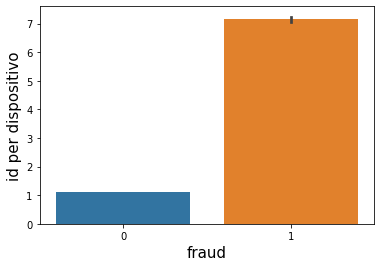

In [43]:
# amount of cases for number of id in just one device for cases with fraud or not
sns.barplot(x='fraud', y='id_per_device', data=tmp_df)
plt.xlabel('fraud', fontsize=15)
plt.ylabel('id per dispositivo', fontsize=15)

Text(0, 0.5, 'id per ip')

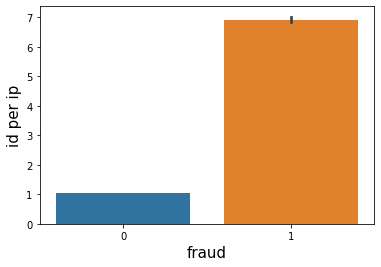

In [44]:
# amount of cases for number of id in just one device for cases with fraud or not
sns.barplot(x='fraud', y='id_per_ip', data=tmp_df)
plt.xlabel('fraud', fontsize=15)
plt.ylabel('id per ip', fontsize=15)

The number of positive cases of even fraud when there is more than one device or ip registered to a user is a considerable factor.


# Chapter 03 - most important variables

In this chapter we will carry out some analysis and apply some algorithms to check the variables that best indicate whether the case is fraud or not.

First create some new columns to improve the analyses.

In [45]:
# the amount of id per device
user_id_count3 = fraud_df.groupby('id_divice').id.count()
fraud_df['id_per_device'] = fraud_df.id_divice.apply(lambda x: user_id_count3[x])

fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country,id_per_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [46]:
# the amount of ip per device
user_id_count4 = fraud_df.groupby('ip').id.count()
fraud_df['id_per_ip'] = fraud_df.ip.apply(lambda x: user_id_count4[x])

fraud_df.head()


,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country,id_per_device,id_per_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


Create a mean column to indicate the mean value between id_per_device and id_per_ip

In [47]:
fraud_df['mean_id'] = (fraud_df.id_per_device + fraud_df.id_per_ip)/2

fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country,id_per_device,id_per_ip,mean_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


Use the register and the purchase columns as datetime used in pandas.

In [48]:
fraud_df.register = fraud_df.register.apply(pd.to_datetime)
fraud_df.purchase = fraud_df.purchase.apply(pd.to_datetime)

Add a column to indicathe the gap between register and purchase:

In [49]:
# adicionar coluna para colocar número de segundos entre tempo e inscrição
fraud_df['time_reg_purch'] = (fraud_df.purchase - fraud_df.register).apply(lambda x: x.seconds)

fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country,id_per_device,id_per_ip,mean_id,time_reg_purch
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


Apply the One Hot Encoding on the countries column to use this data in the future models

In [50]:
country_dummies = pd.get_dummies(fraud_df.country, prefix='country')
fraud_df = pd.concat([fraud_df, country_dummies], axis=1)

fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country,id_per_device,id_per_ip,mean_id,time_reg_purch,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,country_Botswana,...,country_Saint Kitts and Nevis,country_Saint Martin,country_San Marino,country_Saudi Arabia,country_Senegal,country_Serbia,country_Seychelles,country_Singapore,country_Slovakia (SLOVAK Republic),country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Apply the one hot encoding to the source, browser and gender columns:

In [51]:
gender_dummies = pd.get_dummies(fraud_df.gender, prefix='gender')
browser_dummies = pd.get_dummies(fraud_df.browser, prefix='browser')
source_dummies = pd.get_dummies(fraud_df.source, prefix='source')


fraud_dummies = pd.concat([fraud_df, gender_dummies, browser_dummies, source_dummies], axis=1)

fraud_dummies.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country,id_per_device,id_per_ip,mean_id,time_reg_purch,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,country_Botswana,...,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,gender_F,gender_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0


Now drop the colmuns we will no use:

In [52]:
fraud_dummies.drop(['id',
               'register',
                'id_divice',
                'ip',
               'purchase',
               'id_per_device',
               'id_per_ip',
               'country',
               'source',
               'browser',
               'gender',
               'age',
               'value'], axis=1, inplace=True)

In [53]:
fraud_dummies.head()

,fraud,mean_id,time_reg_purch,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,country_Botswana,country_Brazil,country_British Indian Ocean Territory,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cambodia,country_Cameroon,country_Canada,country_Cape Verde,country_Cayman Islands,country_Chile,country_China,...,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,gender_F,gender_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO
0,0,1.0,13882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
1,0,1.0,17944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,1,12.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,0,1.0,60085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,0,1.0,41461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0


In [54]:
country_dummies.sum()

country_Afghanistan                6
country_Albania                   13
country_Algeria                  122
country_Angola                    24
country_Antigua and Barbuda        3
                                ... 
country_Viet Nam                 550
country_Virgin Islands (U.S.)      3
country_Yemen                      1
country_Zambia                    10
country_Zimbabwe                   6
Length: 181, dtype: int64

We have to verify if the mean_id and the time_reg_purch need to be changed to a gaussian distribution. 

First see the distribution of the mean_id column:

Text(0, 0.5, 'count')

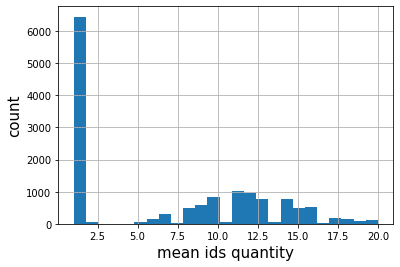

In [55]:
fraud_df[fraud_df['fraud'] == 1].mean_id.hist(bins=25)
plt.xlabel('mean ids quantity', fontsize = 15)
plt.ylabel('count', fontsize=15)

# temos uma distribuição próxima da normal,mas é um poico inicial, indicando uma bimodal
# não temos o que fazer para tornar normal o a distribuuão da fraude

The mean_id columns has a gaussian distribution. We do not have to change or apply a transformation. 

Now the distribution of the time_reg_purch column:


Text(0, 0.5, 'count')

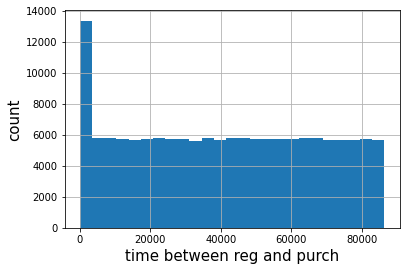

In [56]:
fraud_df.time_reg_purch.hist(bins=25)
plt.xlabel('time between reg and purch', fontsize = 15)
plt.ylabel('count', fontsize=15)

# temos uma distribuição uniforme 
# queremos transfporar para distribuição de forma normal

The time_reg_purch column has a uniform distribution. For that column we have to apply a transformation:

In [57]:
# function to transform the data
def rescale_series(ser):
  ser_min = ser.min() - 1e-5
  ser_max = ser.max() + 1e-5
  new_ser = (ser - ser_min) / (ser_max - ser_min)
  new_ser = new_ser.apply(lambda x: np.sqrt(2)*special.erfinv(2*x - 1))
  return new_ser

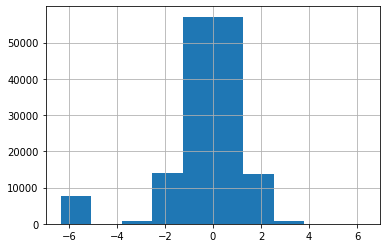

In [58]:
temp = fraud_dummies['time_reg_purch']

temp = rescale_series(temp)

temp.hist()

Now apply the function:

In [59]:
fraud_dummies['time_reg_purch'] = rescale_series(fraud_dummies.time_reg_purch)

Now separete the target data from the feature data:

In [60]:
X = fraud_dummies[ [col for col in fraud_dummies.columns if col != "fraud"]]
Y = fraud_dummies["fraud"]

In [61]:
X.head() 

,mean_id,time_reg_purch,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,country_Botswana,country_Brazil,country_British Indian Ocean Territory,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cambodia,country_Cameroon,country_Canada,country_Cape Verde,country_Cayman Islands,country_Chile,country_China,country_Colombia,...,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,gender_F,gender_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO
0,1.0,-0.991735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
1,1.0,-0.814503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,12.0,-6.338850,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,1.0,0.511309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,1.0,-0.050474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0


In [62]:
Y.head() 

0    0
1    0
2    1
3    0
4    0
Name: fraud, dtype: int64

Save this new data

In [63]:
X.to_csv('/content/drive/MyDrive/Alura/detec_fraude/X.csv', index = False)
Y.to_csv('/content/drive/MyDrive/Alura/detec_fraude/Y.csv', index = False)

In [64]:
fraud_df = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/data_fraud_with_country', header = 0)

fraud_df.head()

,id,register,purchase,value,id_divice,source,browser,gender,age,ip,fraud,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [ ]:
X = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/X.csv')
Y = pd.read_csv('/content/drive/MyDrive/Alura/detec_fraude/Y.csv')

In [65]:
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: fraud, dtype: int64

Now using the ExtraTreesClassifier verify the most importante features of the dataset:

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
clf.fit(X,Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_

features [features.importance > np.mean(features.importance)].sort_values(by="importance", ascending=False)

,feature,importance
1,time_reg_purch,0.667169
0,mean_id,0.298532


The time_reg_purch and the mean_id features were the ones that most impacted the creation of fraud prediction models.


# Chapter 04 - Create the predictive model

In this session we will create different algorithms to classify accesses as fraud and non-fraud.

## Use supervised algorithms




Primeiro usar algoritmo de floresta de isolamento. Seleciona aleatoriamente uma variável para isolar as observaç~eos. de forma recursiva ele seleciona outras variáveis apra tentar separar a nossa amostra. 



In [67]:
from sklearn.preprocessing import RobustScaler # remove a mediana e dimensiona os dados de acord com a faixa dos quartis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

from sklearn import metrics

First split the data in test and train:

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.75, random_state=23)

We will test three different models: Decision Tree, Random Forest and Isolation Forest

Decision Tree: https://scikit-learn.org/stable/modules/tree.html

Random Forest documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Isolation Forest documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

The Isolation Forest model needs a adaptation in the target column. The positive values for frauds (Y=1) must be equal to -1 and the negative values for frauds (Y=0) must be equal to 1.

Apply this change in the data to use the Isolation Tree model:

In [70]:
Y

0         0
1         0
2         1
3         0
4         0
         ..
151107    1
151108    0
151109    0
151110    0
151111    0
Name: fraud, Length: 151112, dtype: int64

In [71]:
Y_train.head()

93710    0
22227    0
69819    0
37926    0
76236    0
Name: fraud, dtype: int64

In [72]:
Y_train_test = pd.Series(Y_train)
Y_test_test = pd.Series(Y_test)

In [73]:
Y_train_IF = Y_train.apply(lambda x: 1 if x == 0 else -1)
Y_test_IF = Y_test.apply(lambda x: 1 if x == 0 else -1)

Create the three models. First use the default parameters and than search for better ones using the grid search:

In [104]:
IF_clf = IsolationForest(max_samples='auto', contamination=0.095, random_state=1)
RF_clf = RandomForestClassifier()
DT_clf = DecisionTreeClassifier()

Train the models:

In [105]:
IF_clf.fit(X_train, Y_train_IF)
RF_clf.fit(X_train, Y_train)
DT_clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The predictions:

In [106]:
Y_predict_IF = IF_clf.predict(X_test)
Y_predict_RF = RF_clf.predict(X_test)
Y_predict_DT = DT_clf.predict(X_test)

Create a function no analyse the results. We will analyse the results using the precision, recall, f1-score, support, ROC and the confusion matrix.

In [92]:
def see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted, model):
  # ver os resultados obtidos
  # roc_auc = roc_auc_score(Y_test, Y_predicted)

  print(classification_report(Y_test,
                              Y_predicted,
                              target_names=['fraud', 'normal']))

  model = model

  metrics.plot_roc_curve(model, X_test, Y_test)  

  plt.plot([0,1], [0,1], '--', color=(0.6,0.6,0.6), label = 'sorte')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])

  plt.title('ROC', fontsize=12)

  plt.show()

In [108]:
def see_results_IF(X_test, Y_test_IF, Y_predict_IF):

  roc_auc = roc_auc_score(Y_test_IF, Y_predict_IF)

  print(classification_report(Y_test_IF,
                              Y_predict_IF,
                              target_names=['fraud', 'normal']))

  print('AUC: {:0.3f}'. format(roc_auc))

  IF_probs = IF_clf.decision_function(X_test)

  fpr, tpr, threshold = roc_curve(Y_test_IF, IF_probs)

  plt.plot(fpr, tpr, lw=1)

  # comparar com a curva do resultado na sorte
  plt.plot([0,1], [0,1], '--', color=(0.6,0.6,0.6), label = 'random')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])

  plt.ylabel('True Positive Rate', fontsize=11)
  plt.xlabel('False Positive Rate', fontsize=11)
  plt.title('ROC', fontsize=12)

  plt.show()

              precision    recall  f1-score   support

       fraud       0.95      0.96      0.96     34232
      normal       0.62      0.56      0.59      3546

    accuracy                           0.93     37778
   macro avg       0.79      0.76      0.77     37778
weighted avg       0.92      0.93      0.92     37778



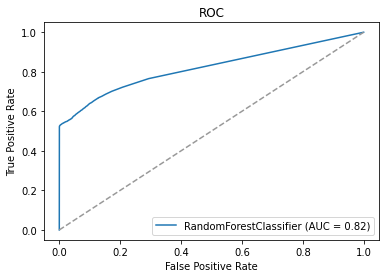

In [109]:
see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted = Y_predict_RF, model = RF_clf)

              precision    recall  f1-score   support

       fraud       0.95      0.96      0.96     34232
      normal       0.61      0.56      0.59      3546

    accuracy                           0.93     37778
   macro avg       0.78      0.76      0.77     37778
weighted avg       0.92      0.93      0.92     37778

AUC: 0.762


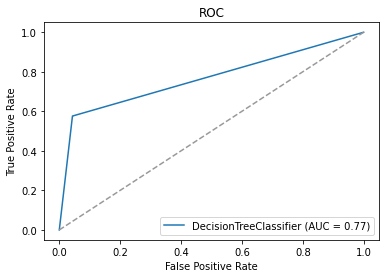

In [ ]:
see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted = Y_predict_RF, model = DT_clf)

              precision    recall  f1-score   support

       fraud       0.44      0.45      0.44      3546
      normal       0.94      0.94      0.94     34232

    accuracy                           0.89     37778
   macro avg       0.69      0.70      0.69     37778
weighted avg       0.90      0.89      0.90     37778

AUC: 0.695


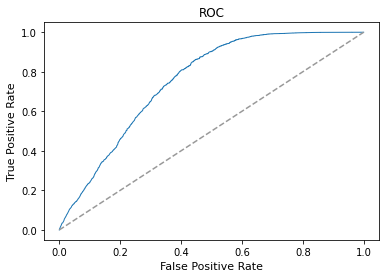

In [110]:
see_results_IF(X_test, Y_test_IF, Y_predict_IF)

Now apply the grid search to find the best hyperparameters for each model.

In [115]:
np.linspace(1,40,40)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40.])

In [125]:
# for the Decision Tree classifier
param_grid_DT = {'max_depth': np.linspace(1,30,30),
                 'min_samples_split': np.linspace(1,10,10),
                 'max_features': ['auto', 'sqrt', 'log2']}

DT_clf = DecisionTreeClassifier()

clf_gridsearch_DT = GridSearchCV(DT_clf,
                                  param_grid_DT,
                                  cv=5,
                                  n_jobs=10,
                                  scoring='f1',
                                  verbose=10)


clf_gridsearch_DT.fit(X_train, Y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   15.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   19.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   21.4s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   23.5s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   26.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   28.6s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   32.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   34.7s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:   38.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   41.2s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=10,
             param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., 

In [117]:
print(clf_gridsearch_DT.best_params_)

{'max_depth': 27.0, 'max_features': 'log2', 'min_samples_split': 1.0}


              precision    recall  f1-score   support

       fraud       0.95      1.00      0.98     34232
      normal       1.00      0.52      0.69      3546

    accuracy                           0.96     37778
   macro avg       0.98      0.76      0.83     37778
weighted avg       0.96      0.96      0.95     37778



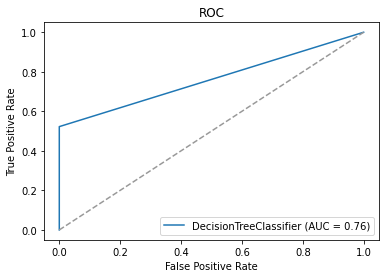

In [131]:
DT_best = clf_gridsearch_DT.best_estimator_

Y_predict_gridsearch_test_df = DT_best.predict(X_test)

see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted = Y_predict_gridsearch_test_df, model = DT_best)

In [143]:
type(np.linspace(1,300,300).astype(int)[0])

numpy.int64

In [ ]:
# for the Random Forest
param_grid_RF = {'n_estimators': np.linspace(1,300,300).astype(int),
                 'max_features': ['auto']}


clf_gridsearch_RF = GridSearchCV(RF_clf,
                                  param_grid_RF,
                                  cv=5,
                                  n_jobs=10,
                                  scoring='f1',
                                  verbose=10)


clf_gridsearch_RF.fit(X_train, Y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   18.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   34.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   52.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 11.8min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed: 15.1min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 18.3min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       fraud       0.91      1.00      0.95     34232
      normal       0.00      0.00      0.00      3546

    accuracy                           0.91     37778
   macro avg       0.45      0.50      0.48     37778
weighted avg       0.82      0.91      0.86     37778



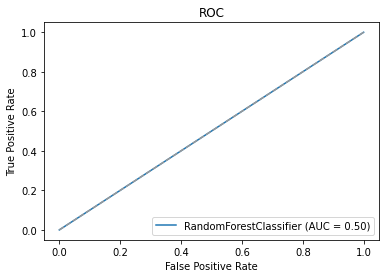

In [136]:
RF_best = clf_gridsearch_RF.best_estimator_

Y_predict_gridsearch_test_RF = RF_best.predict(X_test)

see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted = Y_predict_gridsearch_test_RF, model = RF_best)

In [ ]:
# for the Isolation Forest
param_grid_IF = {'n_estimators': [100, 150, 200, 250, 300]}

clf_gridsearch_IF = GridSearchCV(IF_clf,
                                  param_grid_IF,
                                  cv=5,
                                  n_jobs=10,
                                  scoring='f1',
                                  verbose=10)


clf_gridsearch_IF.fit(X_train, Y_train_IF)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   38.1s
[Parallel(n_jobs=10)]: Done   9 out of  25 | elapsed:  2.8min remaining:  5.0min
[Parallel(n_jobs=10)]: Done  12 out of  25 | elapsed:  3.4min remaining:  3.6min
[Parallel(n_jobs=10)]: Done  15 out of  25 | elapsed:  3.5min remaining:  2.3min
[Parallel(n_jobs=10)]: Done  18 out of  25 | elapsed:  6.1min remaining:  2.4min
[Parallel(n_jobs=10)]: Done  21 out of  25 | elapsed:  6.5min remaining:  1.2min
[Parallel(n_jobs=10)]: Done  25 out of  25 | elapsed:  6.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False),
             iid='deprecated', n_jobs=10,
             param_grid={'n_estimators': [100, 150, 200, 250, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=10)

Save the best parameters for each model:

In [ ]:
import joblib

In [ ]:
joblib.dump(clf_gridsearch_DT.best_estimator_, '/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_DT.pkl')
joblib.dump(clf_gridsearch_RF.best_estimator_, '/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_RF.pkl')
joblib.dump(clf_gridsearch_IF.best_estimator_, '/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_IF.pkl')

['/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_IF.pkl']

In [ ]:
clf_gridsearch_DT = joblib.load('/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_DT.pkl')
clf_gridsearch_RF = joblib.load('/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_RF.pkl')
clf_gridsearch_IF = joblib.load('/content/drive/MyDrive/Alura/detec_fraude/clf_gridsearch_IF.pkl')

The new predictions with the parameters tuned:

In [ ]:
Y_predict_gridsearch_DT = clf_gridsearch_DT.predict(X_test)
Y_predict_gridsearch_RF = clf_gridsearch_RF.predict(X_test)
Y_predict_gridsearch_IF = clf_gridsearch_IF.predict(X_test)

Now see the results for the models with parameters tuned:

              precision    recall  f1-score   support

       fraud       0.95      0.99      0.97     34232
      normal       0.90      0.53      0.66      3546

    accuracy                           0.95     37778
   macro avg       0.93      0.76      0.82     37778
weighted avg       0.95      0.95      0.94     37778

AUC: 0.760


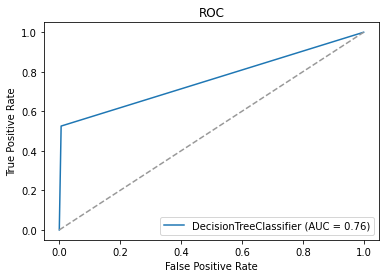

In [ ]:
see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted = Y_predict_gridsearch_DT, model = clf_gridsearch_DT)

              precision    recall  f1-score   support

       fraud       0.95      0.99      0.97     34232
      normal       0.90      0.53      0.66      3546

    accuracy                           0.95     37778
   macro avg       0.93      0.76      0.82     37778
weighted avg       0.95      0.95      0.94     37778

AUC: 0.760


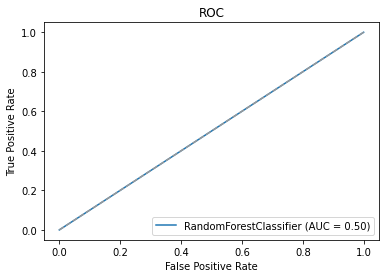

In [ ]:
see_results_DT_RF(X_train, Y_train, X_test, Y_test, Y_predicted = Y_predict_gridsearch_DT, model = clf_gridsearch_RF)

# Chapter 05 - Conclusions

1. Company recommendations:

* Small time between purchase and registration characterizes fraud;
* The amount of ips associated with a single user id can sugest fraud; 
* Initial weeks of the year have a significant increase in the amount of fraud;
* the most sensitive cases for these studies are the cases that were characterized as non-fraudulent but are fraudulent (false negatives). 
* We used a simpler version (decision tree) that had better results. Larger area under the curve and fewer false negatives.

2. Some suggestions for the client:

* Require full name, address and email address of new users;
* After the user signs up, presents offers and discounts immediately so that the time to purchase other products and identify bots is reduced;
* Strongly recommend increasing security in the first weeks of the year;
* If the model identifies the user as a bot, ask to answer security questions or CAPTCHAS.